# 0. 영화 추천 시스템

추천 시스템은 크게 협업 필터링과 컨텐트 기반 필터링 두 개가 있다.  

협업 필터링은 다수의 사용자의 아이템 구매 이력 정보만으로 사용자간 유사성 및 아이템 간 유사성을 파악하지만,  
컨텐트 기반 필터링은 아이템의 고유의 정보를 바탕으로 아이템 간 유사성을 파악한다.  
다시 말해, 협업 필터링에서는 아이템과 사용자 간의 행동 또는 관계에만 주목할 뿐 아이템 자체의 고유한 속성에 주목하지 않는다.  
컨텐트 기반 필터링에서는 아이템 자체의 속성에만 주목하고 사용자와 아이템 간의 관련성 에는 주목하지 않는다.

이번 시간에는 유저가 좋아하는 특정 영화와 유사한 다른 영화를 추천하는 협업 필터링 추천 시스템을 만들어 보도록 하자.

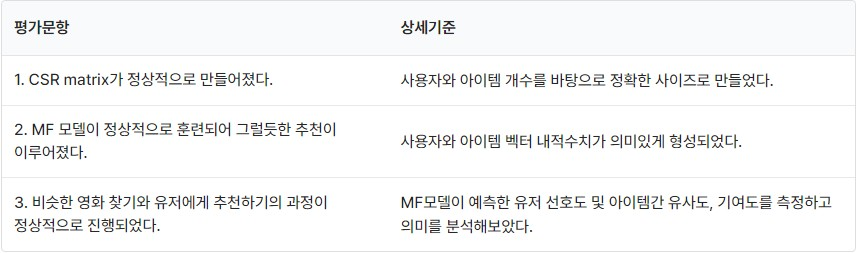

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

# 1. 데이터 준비와 전처리하기

영화에 대한 유저별 평점이 들어있는 Movielens 1M Dataset을 이용한다.

https://grouplens.org/datasets/movielens/1m/

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

이 파일들은 2000년 무비렌즈에 가입한 6,040명의 무비렌즈 사용자들이 만든 약 3,900편의 익명 평가 1,000,209개를 담고 있다.

In [2]:
ratings_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
data_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
data = pd.read_csv(ratings_file_path, sep='::', names=data_cols, engine='python', encoding="ISO-8859-1")
data


,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


https://files.grouplens.org/datasets/movielens/ml-1m-README.txt



RATINGS FILE DESCRIPTION
================================================================================

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

레이팅 데이터에는 유저 아이디, 영화 아이디, 평점, 타임스탬프 총 4개의 변수가 있으며,  
각 유저들은 최소 20개의 영화를 평가했다.

타임스탬프 변수는 필요없으니 버리도록 하겠다.

In [3]:
data_using_cols = ['user_id', 'movie_id', 'rating']
data = data[data_using_cols]
data

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외해보자.

In [4]:
original_data_size = len(data)

# 3점 이상만 남깁니다.
data = data[data['rating'] >= 3]
filtered_data_size = len(data)

print(f'orginal_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / original_data_size:.2%}')
data

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000203,6040,1090,3
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


약 16% 데이터가 제거되었다.

우리는 사용자들이 영화를 얼마나 선호하는지를 모델링 하기를 원한다.  
그러자면 사용자의 영화 선호도를 말해 주는 유저 행동 데이터셋이 필요하다.  
좋아요나 별점같은 선호도를 명시적(explicit) 피드백, 시청 횟수나 구매 내역 같은 것들을 암묵적(implicit) 피드백이라고 부른다.  
이렇게 서비스를 사용하면서 자연스럽게 발생하는 암묵적(implicit)인 피드백도 사용자의 아이템에 대한 평가를 알 수 있는 단서가 될 수 있다.

우리가 앞으로 만들어갈 모델에서는 암묵적 데이터의 해석을 위해 "많이 재생한 영화에 대해 가중치를 주어서 더 확실히 좋아한다고 판단"하기로 한다.

별점 데이터는 대표적인 explicit 데이터다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있다.
그럼 별점 대신 어떤 지표로 해석해 볼 수 있을까?
필자는 별점을 시청횟수로 해석해서 진행해보도록 하겠다.

In [5]:
# rating 컬럼의 이름을 counts로 바꿉니다.
data.rename(columns={'rating':'counts'}, inplace=True)
data['counts']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: counts, Length: 836478, dtype: int64

첫번째 유저의 데이터들만 불러와보자.

In [6]:
data[data['user_id'] == 1]

,user_id,movie_id,counts
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


아이디가 1인 유저는 총 53개의 영화를 시청했다.  
근데 영화 아이디로는 당연히 영화 제목이 무엇인지 모른다.  
다행히 Movielens 1M Dataset에 영화 아이디에 따른 영화 제목 데이터가 있다.

In [7]:
movies_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
movies_cols = ['movie_id', 'title', 'genres'] 
movies = pd.read_csv(movies_file_path, sep='::', names=movies_cols, engine='python', encoding='ISO-8859-1')
movies


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


MOVIES FILE DESCRIPTION
================================================================================

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

영화 데이터에는 영화 아이디, 제목, 장르 총 3개의 변수가 있으며,  
데이터를 수기로 입력했기 때문에 오류가 있을 수 있다고 한다.

In [8]:
# 검색을 쉽게 하기 위해 영화 문자열을 소문자로 바꿔줍시다.
movies['title'] = movies['title'].str.lower()
movies

,movie_id,title,genres
0,1,toy story (1995),Animation|Children's|Comedy
1,2,jumanji (1995),Adventure|Children's|Fantasy
2,3,grumpier old men (1995),Comedy|Romance
3,4,waiting to exhale (1995),Comedy|Drama
4,5,father of the bride part ii (1995),Comedy
...,...,...,...
3878,3948,meet the parents (2000),Comedy
3879,3949,requiem for a dream (2000),Drama
3880,3950,tigerland (2000),Drama
3881,3951,two family house (2000),Drama


이제 레이팅 데이터와 영화 데이터를 영화 아이디 기준으로 합쳐보도록 하자.

In [9]:
data = pd.merge(data, movies, 'inner', on='movie_id')
data

,user_id,movie_id,counts,title,genres
0,1,1193,5,one flew over the cuckoo's nest (1975),Drama
1,2,1193,5,one flew over the cuckoo's nest (1975),Drama
2,12,1193,4,one flew over the cuckoo's nest (1975),Drama
3,15,1193,4,one flew over the cuckoo's nest (1975),Drama
4,17,1193,5,one flew over the cuckoo's nest (1975),Drama
...,...,...,...,...,...
836473,5851,3607,5,one little indian (1973),Comedy|Drama|Western
836474,5854,3026,4,slaughterhouse (1987),Horror
836475,5854,690,3,"promise, the (versprechen, das) (1994)",Romance
836476,5938,2909,4,"five wives, three secretaries and me (1998)",Documentary


In [10]:
print(movies[movies['movie_id']==1193])
print()
print(data[data['movie_id']==1193].head(1))

      movie_id                                   title genres
1176      1193  one flew over the cuckoo's nest (1975)  Drama

   user_id  movie_id  counts                                   title genres
0        1      1193       5  one flew over the cuckoo's nest (1975)  Drama


두 데이터의 같은 영화 아이디에 대해 같은 제목을 가지고 있는 것을 보아  
데이터가 잘 병합된 것을 볼 수 있다.

In [11]:
print(f'filtered_data_size: {filtered_data_size}, merged_data_size: {len(data)}')

filtered_data_size: 836478, merged_data_size: 836478


없어진 데이터도 없다.

추가적으로 좀 더 보기 편하도록 유저 아이디 기준으로 sort도 해주고,  
이제 필요 없어진 영화 아이디랑 장르 변수를 제거하도록 하겠다.

In [12]:
data = data.sort_values('user_id').drop(['movie_id', 'genres'], axis=1)
data

,user_id,counts,title
0,1,5,one flew over the cuckoo's nest (1975)
31113,1,4,antz (1998)
31674,1,4,"girl, interrupted (1999)"
32044,1,4,hercules (1997)
32415,1,4,aladdin (1992)
...,...,...,...
657728,6040,4,vanya on 42nd street (1994)
393446,6040,4,m*a*s*h (1970)
253075,6040,3,big night (1996)
127665,6040,3,shakespeare in love (1998)


# 2. 데이터 분석하기

추천 모델을 만들기 전에 데이터의 기본적인 정보를 보고 가보자.

In [13]:
# 영화 수
data['title'].nunique()

3628

In [14]:
# 유저 수
data['user_id'].nunique()

6039

groupby 메소드를 이용해서 영화 별 평가 수를 세보도록 하자.

In [15]:
# 인기 많은 영화
movie_count_user = data.groupby('title').count()['user_id']
movie_count_user.sort_values(ascending=False).head(30)

title
american beauty (1999)                                   3211
star wars: episode iv - a new hope (1977)                2910
star wars: episode v - the empire strikes back (1980)    2885
star wars: episode vi - return of the jedi (1983)        2716
saving private ryan (1998)                               2561
terminator 2: judgment day (1991)                        2509
silence of the lambs, the (1991)                         2498
raiders of the lost ark (1981)                           2473
back to the future (1985)                                2460
matrix, the (1999)                                       2434
jurassic park (1993)                                     2413
sixth sense, the (1999)                                  2385
fargo (1996)                                             2371
braveheart (1995)                                        2314
men in black (1997)                                      2297
schindler's list (1993)                                  2257
pr

가장 인기가 많은 영화는 아메리칸 뷰티이고, 3211번 평가된 것을 볼 수 있다.

이번에는 유저 별로 몇 개의 영화를 평가했는지 알아보도록 하자.

In [16]:
# 유저별 몇 개의 영화를 보고 있는지에 대한 통계
user_count_movie = data.groupby('user_id').count()['title']
user_count_movie.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

가장 많이 영화를 본 유저는 1968개의 영화를 평가한 것을 알 수 있고,  
평균적으로 138개의 영화를, 중앙값으로는 81개의 영화를 본 것을 알 수 있다.

유저별로 하나의 영화를 보통(중앙값) 몇 번을 봤는지에 대해 알아보도록 하자.

In [17]:
# 유저별 영화 시청 횟수 중앙값에 대한 통계
user_median_counts = data.groupby('user_id').median()['counts']
user_median_counts.describe()

count    6039.000000
mean        4.055970
std         0.432143
min         3.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: counts, dtype: float64

# 3. 유저가 선호하는 영화 추가하기

영화 추천 시스템을 적용시킬 유저 데이터(hugh)를 새로 넣어 주도록 하자.

## 3.1. 영화 찾아보기

영화 이름의 일부 문자를 넣으면 전체 이름을 출력해주는 함수를 생성해보자.

In [18]:
def find_movie(movie):
    return movies[movies['title'].str.contains(movie)]

hugh가 좋아할 만한 영화 이름 5개를 찾아보겠다.(2000년 이전 영화들 뿐이라 hugh가 본 영화는 존재하지 않는다.)

In [19]:
find_movie('star wars')

,movie_id,title,genres
257,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi
1178,1196,star wars: episode v - the empire strikes back...,Action|Adventure|Drama|Sci-Fi|War
1192,1210,star wars: episode vi - return of the jedi (1983),Action|Adventure|Romance|Sci-Fi|War
2559,2628,star wars: episode i - the phantom menace (1999),Action|Adventure|Fantasy|Sci-Fi


In [20]:
find_movie('terminator')

,movie_id,title,genres
585,589,terminator 2: judgment day (1991),Action|Sci-Fi|Thriller
1220,1240,"terminator, the (1984)",Action|Sci-Fi|Thriller


In [21]:
find_movie('back to the')

,movie_id,title,genres
1250,1270,back to the future (1985),Comedy|Sci-Fi
1794,1863,major league: back to the minors (1998),Comedy
1942,2011,back to the future part ii (1989),Comedy|Sci-Fi
1943,2012,back to the future part iii (1990),Comedy|Sci-Fi|Western


In [22]:
find_movie('matrix')

,movie_id,title,genres
2502,2571,"matrix, the (1999)",Action|Sci-Fi|Thriller


In [23]:
find_movie('men in black')

,movie_id,title,genres
1539,1580,men in black (1997),Action|Adventure|Comedy|Sci-Fi


스타 워즈, 터미네이터, 백 투 더 퓨처, 매트릭스, 멘 인 블랙 5개의 영화 평가 데이터를 삽입.

In [24]:
# 본인이 좋아하시는 영화로 추가하셔도 됩니다! 단, 이름은 꼭 데이터셋에 있는 것과 동일하게 맞춰주세요. 
hugh_movies = ["star wars: episode iv - a new hope (1977)", "terminator 2: judgment day (1991)", \
             "back to the future (1985)", "matrix, the (1999)", "men in black (1997)"]

# hugh이라는 user_id가 위 영화를 5회씩 봤다고 가정하겠습니다.
hugh_data = pd.DataFrame({'user_id': ['hugh'] * 5, 'title': hugh_movies, 'counts':[5] * 5})
    
if not data.isin({'user_id':['hugh']})['user_id'].any():  # user_id에 'hugh'이라는 데이터가 없다면
    data = data.append(hugh_data)                           # 위에 임의로 만든 favorite_movies 데이터를 추가해 줍니다. 

data.tail(10)


,user_id,counts,title
657728,6040,4,vanya on 42nd street (1994)
393446,6040,4,m*a*s*h (1970)
253075,6040,3,big night (1996)
127665,6040,3,shakespeare in love (1998)
738957,6040,4,twin falls idaho (1999)
0,hugh,5,star wars: episode iv - a new hope (1977)
1,hugh,5,terminator 2: judgment day (1991)
2,hugh,5,back to the future (1985)
3,hugh,5,"matrix, the (1999)"
4,hugh,5,men in black (1997)


In [25]:
hugh_movies_genres = movies[movies['title'].apply(lambda x: x in hugh_movies)]

장르를 살펴보니 전부 다 SF 영화이고 대부분 액션도 포함되어 있다.

## 3.2. 모델에 활용하기 위한 전처리하기

학습을 할 수 있게끔 데이터들을 인덱싱한다.

In [26]:
# 고유한 유저, 영화를 찾아내는 코드
user_unique = data['user_id'].unique()
movie_unique = data['title'].unique()
print('user_unique:', user_unique)
print()
print('movie_uniuqe:', movie_unique)

user_unique: [1 2 3 ... 6039 6040 'hugh']

movie_uniuqe: ["one flew over the cuckoo's nest (1975)" 'antz (1998)'
 'girl, interrupted (1999)' ... 'slaughterhouse (1987)'
 'five wives, three secretaries and me (1998)'
 'identification of a woman (identificazione di una donna) (1982)']


데이터를 인덱싱하기 위한 딕셔너리를 생성한다.

In [27]:
# 유저, 영화 indexing 하는 코드 idx는 index의 약자입니다.
user_to_idx = {v: k for k, v in enumerate(user_unique)}
movie_to_idx = {v: k for k, v in enumerate(movie_unique)}

In [28]:
# 인덱싱이 잘 되었는지 확인해 봅니다. 
print(user_to_idx['hugh'])    # 6040명의 유저 중 마지막 유저이니 6039이 나와야 합니다. 
print(movie_to_idx["star wars: episode iv - a new hope (1977)"])


6039
15


In [29]:
# indexing을 통해 데이터 컬럼 내 값을 바꾸는 코드
# dictionary 자료형의 get 함수는 https://wikidocs.net/16 을 참고하세요.

# user_to_idx.get을 통해 user_id 컬럼의 모든 값을 인덱싱한 Series를 구해 봅시다. 
# 혹시 정상적으로 인덱싱되지 않은 row가 있다면 인덱스가 NaN이 될 테니 dropna()로 제거합니다. 
temp_user_data = data['user_id'].map(user_to_idx.get).dropna()

if len(temp_user_data) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('user column indexing OK!!')
    data['user'] = temp_user_data   # data['user_id']을 인덱싱된 Series로 교체해 줍니다. 
    
else:
    print('user column indexing Fail!!')

# movie_to_idx을 통해 movie 컬럼도 동일한 방식으로 인덱싱해 줍니다. 
temp_movie_data = data['title'].map(movie_to_idx.get).dropna()

if len(temp_movie_data) == len(data):
    print('movie column indexing OK!!')
    data['movie'] = temp_movie_data
    
else:
    print('movie column indexing Fail!!')
    
data


user column indexing OK!!
movie column indexing OK!!


,user_id,counts,title,user,movie
0,1,5,one flew over the cuckoo's nest (1975),0,0
31113,1,4,antz (1998),0,1
31674,1,4,"girl, interrupted (1999)",0,2
32044,1,4,hercules (1997),0,3
32415,1,4,aladdin (1992),0,4
...,...,...,...,...,...
0,hugh,5,star wars: episode iv - a new hope (1977),6039,15
1,hugh,5,terminator 2: judgment day (1991),6039,156
2,hugh,5,back to the future (1985),6039,46
3,hugh,5,"matrix, the (1999)",6039,76


인덱싱된 열들이 추가된 모습이다.  
인덱싱 변환 사전을 따로 만들었으므로 보기 편하게 기존 열들을 삭제하도록 한다.

In [30]:
data = data.drop(['user_id', 'title'], axis=1)
data

,counts,user,movie
0,5,0,0
31113,4,0,1
31674,4,0,2
32044,4,0,3
32415,4,0,4
...,...,...,...
0,5,6039,15
1,5,6039,156
2,5,6039,46
3,5,6039,76


# 4. CSR matrix 만들기(평가 1)

협업 필터링이란 평가 행렬(Rating Matrix)을 전재로 한다.  
평가 행렬(Rating Matrix)이란 m명의 사용자들의 n개의 영화에 대한 시청 횟수를 포함한 (m,n) 사이즈의 행렬을 말한다.  
아래는 평가 행렬 예시이다.

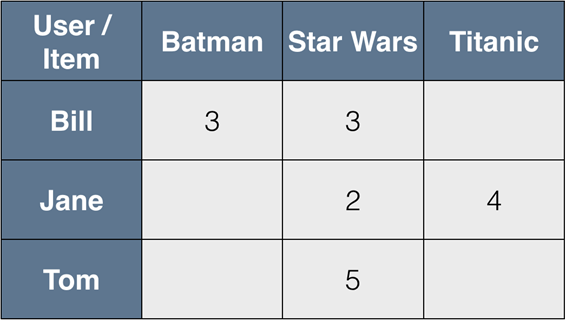

In [31]:
num_user = data['user'].nunique()
num_movie = data['movie'].nunique()
print(f'Rating Matrix: {num_user} x {num_movie} = {num_user * num_movie}')

Rating Matrix: 6040 x 3628 = 21913120


하지만 우리의 평가 행렬의 데이터는 21,913,120개의 값이 들어있다.  
하나당 1Byte라고 치면 약 20MB 행렬이 된다.  
만약 데이터가 더 늘어나서 60만 x 30만 행렬이 만들어 진다면  
무려 167GB 짜리 행렬이 만들어진다.  
하지만 막상 데이터를 살펴보면 각 유저당 본 영화보다 보지 않은 영화가  
더 많기 때문에 값이 대부분 0일 것이다.  
이러한 행렬을 Sparse matrix라고 한다.

이러한 문제를 해결하기 위한 새로운 패러다임이 있다.  
바로 Compressed Sparse Row Matrix, 줄여서 CSR Matrix라고 불리는 행렬이다.  
CSR Matrix는 Sparse matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여  
메모리 사용량을 최소화하면서도 Sparse matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조다.  
CSR Matrix는 data, indices, indptr 로 행렬을 압축하여 표현한다. 그 원리를 아래 행렬 예시를 통해 설명하겠다.

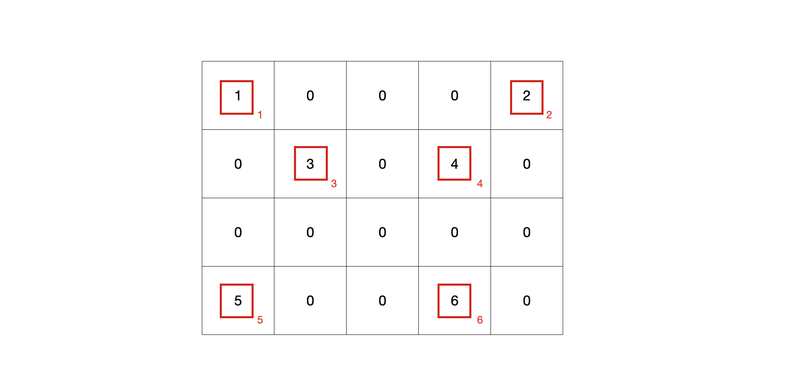

data = [1, 2, 3, 4, 5, 6]  
data는 0이 아닌 원소를 차례로 기입한 값이다.

indices = [0, 4, 1, 3, 0, 3]  
indices는 data의 각 요소가 어느 열(column)에 있는지를 표현한 index이다.

indptr = [0, 2, 4, 4, 6]  
indptr은 최초 시작 행 번호, 시작행의 데이터 개수, 두번째 행에서의 데이터 누적 개수, ..., 마지막행에서의 데이터 누적 개수이다.  
이를 통해 data의 요소들이 어느 행(row)에 있는지를 알 수 있다.

이번에는 반대로 data, indices, indptr 세 벡터를 이용해서 평가 행렬을 만들어보자.

Q.  
data = [1, 3, 5, 6, 2, 11, 7, 9, 10, 12]  
indices = [1, 2, 3, 0, 1, 3, 1, 2, 2, 3]  
indptr = [0, 3, 6, 8, 10]

A.  
0 1 3 5  
6 2 0 11  
0 7 9 0  
0 0 10 12

코드로 CSR Matrix를 구현해보자.

In [32]:
csr_data = csr_matrix((data.counts, (data['user'], data['movie'])), shape=(num_user, num_movie))
csr_data

<6040x3628 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [33]:
print(f'Rating Matrix shape: {num_user} x {num_movie}')

Rating Matrix shape: 6040 x 3628


사용자와 아이템 개수를 바탕으로 정확한 사이즈로 만들었다.

# 5. 모델 구성 및 훈련하기

우리가 알고 싶은 것은 결국 유저들의 영화 선호도이기 때문에  
Rating Matrix와 shape가 같지만 값이 시청 횟수가 아닌 선호도(0 ~ 1)인 선호도 행렬을 원한다.  
따라서 알아내야 하는 값이 M x N으로 엄청 많다.  

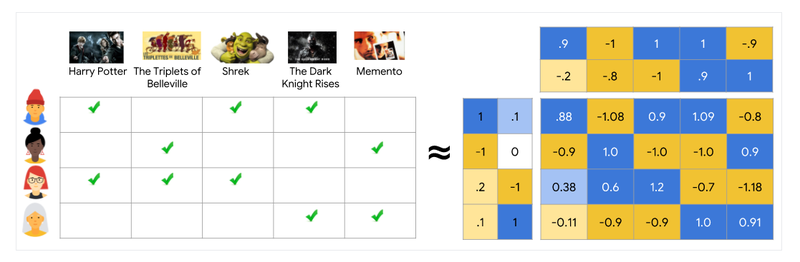

여기에 새로운 패러다임이 있다.  
바로 Matrix Factorization(MF), 행렬 분해이다.

(M, N) 사이즈의 행렬 R을 (M, K) 사이즈의 행렬 P와 (K, N) 사이즈의 행렬 Q로 분해한다면  
R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다는 간단한 아이디어이다.  
P와 Q 행렬을 Feature Matrix, 특성 행렬이라고 한다.  
대체로 k는 m이나 n보다 훨씬 작은 값이기 때문에 계산량 측면으로도 훨씬 유리해진다.  
따라서 이러한 MF 모델을 이용해서 선호도 행렬을 구해보도록 하자.

In [34]:
# Implicit AlternatingLeastSquares 모델의 선언
# factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지
# regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
# use_gpu : GPU를 사용할 것인지
# iterations : epochs와 같은 의미입니다. 데이터를 몇 번 반복해서 학습할 것인지
als_model = AlternatingLeastSquares(factors=2**9, regularization=0.03, use_gpu=False, iterations=2**5, dtype=np.float32)


In [35]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3628x6040 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

In [36]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/32 [00:00<?, ?it/s]

# 6. 유저의 영화 선호도 확인하기(평가 2, 3)

이제 hugh 데이터에 대해 선호도를 파악해보도록 하자.

In [37]:
hugh_idx, star_wars_idx = user_to_idx['hugh'], movie_to_idx["star wars: episode iv - a new hope (1977)"]

# hugh 유저의 특성 벡터와 star wars의 특성 벡터
hugh_vector, star_wars_vector = als_model.user_factors[hugh_idx], als_model.item_factors[star_wars_idx]


In [38]:
hugh_vector

array([ 1.32043406e-01, -1.28342421e-03,  3.62663865e-02,  9.14551318e-02,
        1.30310908e-01, -2.55275488e-01,  9.29062739e-02,  4.24519442e-02,
        2.64907181e-02, -1.20880976e-01,  1.52254626e-01, -4.72280271e-02,
        4.64228168e-03,  4.46665809e-02,  2.64989380e-02,  1.39777988e-01,
        7.54691958e-02, -9.54747871e-02, -3.70531052e-01, -1.23506794e-02,
        3.48777883e-02,  1.16598569e-01, -2.04506293e-01,  8.68006423e-02,
        1.56581581e-01,  8.09859261e-02, -1.21879347e-01, -2.37680703e-01,
        2.70347553e-03,  6.56410754e-02, -1.53665289e-01,  1.92567095e-01,
       -1.15457870e-01, -2.64657348e-01,  2.59574726e-02, -1.05905838e-01,
        5.14271446e-02,  7.77874812e-02, -2.03450844e-01,  7.55953342e-02,
        9.68212485e-02, -1.84163854e-01,  1.41719148e-01,  1.75826848e-01,
       -1.95992604e-01,  1.14175945e-03,  1.15303852e-01, -2.97895193e-01,
       -9.91360918e-02, -6.07566573e-02,  1.93435043e-01,  1.53638572e-01,
       -3.35096270e-02,  

In [39]:
star_wars_vector

array([ 3.10384631e-02, -8.64869263e-03,  1.44948121e-02,  5.00992499e-02,
       -1.21376282e-02, -8.63008481e-03,  1.17679583e-02, -3.73702380e-03,
        8.01038090e-03,  2.46814042e-02,  6.04885444e-02, -1.85593888e-02,
        3.97595428e-02,  2.79522110e-02,  1.07711554e-02,  5.31354360e-02,
        1.86197404e-02, -3.31811160e-02, -2.99120676e-02,  5.59327053e-03,
       -2.10699905e-03, -6.37750258e-04, -1.86741650e-02,  1.34068169e-02,
        3.12330835e-02, -2.55729090e-02,  4.00134474e-02, -1.07285930e-02,
        1.69302300e-02, -2.41237152e-02, -2.09449586e-02,  5.97679093e-02,
        1.05377138e-02, -4.72021429e-03,  4.13151905e-02, -2.25556307e-02,
        2.88479752e-03, -1.20952446e-02, -1.49045754e-02,  3.49235311e-02,
        7.15684984e-03, -3.75815481e-02,  1.17977522e-02,  3.98378680e-03,
       -4.23463807e-02,  2.74663772e-02,  2.08925884e-02, -1.23723978e-02,
       -8.62297695e-03, -4.37755249e-02,  2.16761548e-02,  1.07769519e-02,
        4.07083370e-02, -

유저 벡터와 영화 벡터를 내적하면 비로소 선호도가 나온다.

In [40]:
# hugh과 star_wars을 내적하는 코드
np.dot(hugh_vector, star_wars_vector)

0.94322634

hugh의 starwars 선호도는 95%다.  
hugh가 starwars 영화를 5번이나 봤기 때문에 옳게 된 선호도라고 볼 수 있다.

In [41]:
toy_idx = movie_to_idx['toy story (1995)']
toy_vector = als_model.item_factors[toy_idx]
np.dot(hugh_vector, toy_vector)

0.034758266

hugh의 toy story 선호도는 3%다.  
그렇다면 hugh는 toy story를 정말 선호하지 않을까?  
정답은 hugh 본인만이 알 수 있다.  

사용자와 아이템 벡터 내적수치가 의미있게 형성되었다.  
MF모델이 예측한 유저 선호도의 의미를 분석해보았다.

# 7. 유저가 좋아하는 영화와 비슷한 영화 추천받기(평가 3)

AlternatingLeastSquares 클래스에 구현되어 있는 similar_items 메서드를 통하여 비슷한 영화를 찾을 수 있다.  
hugh가 좋아하는 terminator와 비슷한 영화를 찾아보겠다.

In [42]:
termi = 'terminator 2: judgment day (1991)'
termi_idx = movie_to_idx[termi]
termi_similar_movies = als_model.similar_items(termi_idx, N=15)
termi_similar_movies

[(156, 1.0000001),
 (198, 0.2770914),
 (76, 0.20047392),
 (3268, 0.19793615),
 (145, 0.18825068),
 (3184, 0.18729444),
 (3512, 0.18572457),
 (3481, 0.18389459),
 (3281, 0.17853),
 (3258, 0.17849718),
 (2738, 0.17719935),
 (3544, 0.17714387),
 (3466, 0.17689003),
 (3605, 0.17681344),
 (3157, 0.17578454)]

(영화 idx, 유사도) Tuple 로 반환되었다.  
실제 영화 이름을 알기 위해 변환 사전을 만들고 이름을 추출한다.

In [43]:
# movie_to_idx 를 뒤집어, index로부터 mnovie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v: k for k, v in movie_to_idx.items()}
[idx_to_movie[i[0]] for i in termi_similar_movies]

['terminator 2: judgment day (1991)',
 'terminator, the (1984)',
 'matrix, the (1999)',
 'grosse fatigue (1994)',
 'total recall (1990)',
 'sorority house massacre ii (1990)',
 'city of the living dead (paura nella città dei morti viventi) (1980)',
 'man from down under, the (1943)',
 "i can't sleep (j'ai pas sommeil) (1994)",
 'sixth man, the (1997)',
 'committed (2000)',
 'ulysses (ulisse) (1954)',
 'schlafes bruder (brother of sleep) (1995)',
 'stranger, the (1994)',
 'running free (2000)']

터미네이터2 영화와 비슷한 영화는 역시 터미네이터(1)인 것을 알 수 있고,  
hugh가 시청했던 matrix도 포함되어 있다.

몇 번 더 반복해서 확인하기 위해 위의 코드를 함수로 만든다.

In [44]:
def get_similar_movie(favorite_movie: str):
    favorite_movie_idx = movie_to_idx[favorite_movie]
    similar_favorite_movies = als_model.similar_items(favorite_movie_idx)
    similar_favorite_movies = [idx_to_movie[i[0]] for i in similar_favorite_movies]
    
    return similar_favorite_movies

In [45]:
hugh_movies # hugh가 시청했던 영화 목록.

['star wars: episode iv - a new hope (1977)',
 'terminator 2: judgment day (1991)',
 'back to the future (1985)',
 'matrix, the (1999)',
 'men in black (1997)']

In [46]:
get_similar_movie('back to the future (1985)')

['back to the future (1985)',
 'back to the future part ii (1989)',
 'eaten alive (1976)',
 'anna karenina (1997)',
 'anna (1996)',
 'smoking/no smoking (1993)',
 'small wonders (1996)',
 'prom night iv: deliver us from evil (1992)',
 'arguing the world (1996)',
 'slumber party massacre iii, the (1990)']

백 투 더 퓨처와 유사한 영화에는 역시 백 투 더 퓨처 2가 포함되어 있다.

In [47]:
get_similar_movie('matrix, the (1999)')

['matrix, the (1999)',
 'running free (2000)',
 'second jungle book: mowgli & baloo, the (1997)',
 "mummy's ghost, the (1944)",
 'terminator 2: judgment day (1991)',
 'search for one-eye jimmy, the (1996)',
 'theodore rex (1995)',
 'love, etc. (1996)',
 'home page (1999)',
 'gate ii: trespassers, the (1990)']

아까 터미네이터 2와 유사한 영화를 찾아봤을 때 matrix가 포함되어 있었는데,  
반대로 matrix와 유사한 영화에 터미네이터 2가 포함되어 있는 것을 보아  
학습이 잘 된 것을 확인할 수 있다.

# 8. 유저가 가장 좋아할 만한 영화 추천받기(평가 3)

AlternatingLeastSquares 클래스에 구현되어 있는 recommend 메서드를 통하여  
hugh가 좋아할 만한 영화를 추천받는다.  
filter_already_liked_items 는 유저가 이미 시청한 영화는 제외하는 Argument다.

In [48]:
# recommend에서는 user*item CSR Matrix를 받습니다.
hugh_reco_movie = als_model.recommend(hugh_idx, csr_data, N=20, filter_already_liked_items=True)
hugh_reco_movie


[(145, 0.15543564),
 (198, 0.15321207),
 (73, 0.13773188),
 (138, 0.11213592),
 (377, 0.110690475),
 (103, 0.10137263),
 (200, 0.091005),
 (887, 0.089466095),
 (682, 0.07839368),
 (53, 0.07625421),
 (264, 0.075940505),
 (37, 0.073005915),
 (499, 0.07118415),
 (100, 0.07092616),
 (1278, 0.07085149),
 (183, 0.068808645),
 (281, 0.068584055),
 (1378, 0.0672051),
 (709, 0.06674585),
 (654, 0.06591874)]

In [49]:
[idx_to_movie[i[0]] for i in hugh_reco_movie]

['total recall (1990)',
 'terminator, the (1984)',
 'star wars: episode v - the empire strikes back (1980)',
 'jurassic park (1993)',
 'face/off (1997)',
 'star wars: episode i - the phantom menace (1999)',
 'alien (1979)',
 'sleeper (1973)',
 'back to the future part ii (1989)',
 'fifth element, the (1997)',
 'speed (1994)',
 "ferris bueller's day off (1986)",
 'blade runner (1982)',
 'fugitive, the (1993)',
 "white men can't jump (1992)",
 '28 days (2000)',
 'twelve monkeys (1995)',
 'near dark (1987)',
 'galaxy quest (1999)',
 'beetlejuice (1988)']

In [50]:
hugh_movies_genres

,movie_id,title,genres
257,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi
585,589,terminator 2: judgment day (1991),Action|Sci-Fi|Thriller
1250,1270,back to the future (1985),Comedy|Sci-Fi
1539,1580,men in black (1997),Action|Adventure|Comedy|Sci-Fi
2502,2571,"matrix, the (1999)",Action|Sci-Fi|Thriller


total recall이라는 영화를 가장 추천하고 있다.  
https://namu.wiki/w/%ED%86%A0%ED%83%88%20%EB%A6%AC%EC%BD%9C  
나무위키를 보면 장르가 액션, SF라고 되어 있다.  
hugh가 시청했던 영화들과 장르가 같은 것을 보아  
추천이 매우 잘 되었다고 할 수 있다.

AlternatingLeastSquares 클래스에 구현된 explain 메서드를 사용하면  
hugh가 본 영화들이 이 추천에 얼마나 기여했는지 확인할 수 있다.

In [51]:
future_idx = movie_to_idx['back to the future (1985)']
future_explain = als_model.explain(hugh_idx, csr_data, itemid=future_idx)

In [52]:
[(idx_to_movie[i[0]], i[1]) for i in future_explain[1]]

[('back to the future (1985)', 0.9262294951236358),
 ('matrix, the (1999)', 0.003564650441306291),
 ('star wars: episode iv - a new hope (1977)', 0.002388236658205289),
 ('men in black (1997)', 0.0011581356693533189),
 ('terminator 2: judgment day (1991)', -0.00023701562728133075)]

백 투 더 퓨처가 이 추천에 아주 강력한 기여를 한 것을 볼 수 있다.

MF모델이 예측한 유저 선호도 및 아이템간 유사도, 기여도를 측정하고 의미를 분석해보았다.

# 9. 회고하기

## 9.1. 이번 프로젝트에서 어려웠던 점

이번 프로젝트는 딱히 어렵지는 않았지만 처음 해본 추천 시스템이라  
좀 더 꼼꼼하게 원리를 찾아보고 마크다운을 했다.  
해당 프로젝트가 쉬운 건지 추천 시스템이 쉬운 건지는 모르겠지만  
추천 시스템에 대한 자신감이 생겼다.

## 9.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

추천 시스템에는 협업 필터링과 사용자 기반 필터링 두 종류가 있고  
좀 더 진보된 필터링인 협업 필터링은 각 사용자에 대한 아이템 구매 정보를 이용해서  
좀 더 정확한 추천을 할 수 있다는 것을 알았다.  
하지만 정확이 성능이 얼마나 차이나는지는 알지 못해서  
나중에 기회가 된다면 사용자 기반 필터링과 협업 필터링의 성능 차이가  
얼마나 나는지 확인해 보려고 한다.

## 9.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

1. CSR matrix가 정상적으로 만들어졌다.  
그냥 nuique와 csr_matrix를 이용해서 손 쉽게 CSR matrix를 만들 수 있었다.


2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.  
딱히 accuracy를 측정할 수는 없었지만 선호도를 살펴본 결과 hugh가 자주 봤던 영화들은 선호도가 높았고 상관 없어보이던 영화들은 선호도가 낮게 나와서 추천이 잘 이루어졌다고 볼 수 있다.


3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.  
비슷한 영화를 찾아본 결과 해당 영화와 같은 시리즈들의 영화들이 추천되었다.  
또한 hugh에게 추천한 영화를 살펴보니 자주 봤던 영화들의 장르와 같아서 추천이 잘 되었다고 할 수 있다.

## 9.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

데이터 전처리를 잘하고 데이터 shape를 잘 확인했으면 지표를 달성하기 쉬웠을 것이다.

## 9.5. 자기 다짐

이번엔 꽤 마크다운을 섬세하게 해놔서 만족감이 높았고,  
앞으로 좀 더 마크다운을 자세하게 해놔야겠다.